<a href="https://colab.research.google.com/github/mrhamedani/Gen-AI-projects-Pytorch/blob/main/8_VAE_glasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VAE model
This model is a subset of Autoencoder, but with special features that allow it to remember more complex distributions of data.

VAE (Variational Autoencoder) is a generative model that can generate new data similar to the input data.
This model is specifically designed to learn probability distributions of data.
Encoder is used to generate probability distribution and Decoder is used to reconstruct data.
With the help of KL Divergence and Reconstruction Loss, the model simultaneously learns to reconstruct the data and generate probability distributions similar to standard distributions.

In [17]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
!wget -O glasses.zip "https://mng.bz/GNRR" # In this link, there is a training model so that we don't waste time on training
!unzip  glasses.zip
!kaggle datasets download -d jeffheaton/glasses-or-no-glasses # dataset from kaggle
!unzip glasses-or-no-glasses.zip

#Divide the dataset into G=with glasses, NoG=white glasses

In [18]:
train = pd.read_csv('train.csv')
train.set_index('id',inplace=True)
test = pd.read_csv('test.csv')
test.set_index('id',inplace=True)

os.makedirs('./glasses/G/', exist_ok=True)
os.makedirs('./glasses/NoG/',exist_ok=True)

folder= "./faces-spring-2020/faces-spring-2020/"

for i in range(1, 4501):
    oldpath = f"{folder}face-{i}.png"
    if train.loc[i].glasses == 1:
        newpath = f'./glasses/G/face-{i}.png'  # A new way for pictures with glasses
        shutil.copy(oldpath, newpath)
    else:
        newpath = f'./glasses/NoG/face-{i}.png'  #A new path for glasses-free images
        shutil.copy(oldpath, newpath)

In [20]:
transform = T.Compose([T.Resize(256), T.ToTensor()])
data = torchvision.datasets.ImageFolder(root="./glasses", transform=transform)
batch_size=16
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
latent_dims = 100 # latent space dimension,It's optional, but it's usually the same
class Encoder(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1) #stride=displacement step
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)

        self.linear1 = nn.Linear(31*31*32, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std * self.N.sample(mu.shape)
        # self.N.sample(mu.shape) samples a random noise ε of dimensions mu.shape.
        # self.N = torch.distributions.Normal(0, 1) Creates a standard normal distribution (mean 0 and standard deviation 1)
        return mu, std, z

In [22]:
class Decoder(nn.Module): # decoder is the opposite of the encoder in terms of the number of layers
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 31*31*32),
            nn.ReLU(True),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 31, 31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [23]:
class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z)

In [24]:
class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z)

In [25]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)
# weight_decay = L2 regularization is used to prevent overfitting the model by adding a penalty term to the loss function


In [26]:
def train_epoch(epoch):
    vae.train()
    epoch_loss = 0.0
    for imgs, _ in loader:
        imgs = imgs.to(device)
        mu, std, out = vae(imgs)
        reconstruction_loss = ((imgs-out)**2).sum() # reconstruction loss is MSE
        kl = ((std**2)/2 + (mu**2)/2 - torch.log(std) - 0.5).sum()
        loss = reconstruction_loss + kl # loss for VAE model is the sum of the two
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"at epoch {epoch}, loss is {epoch_loss}")

In [27]:
def plot_epoch():
    with torch.no_grad(): # no_grad() is a context manager that disables gradient computation during inference to save memory and speed up inference
        noise = torch.randn(18, latent_dims).to(device) # random noise to generate images
        imgs = vae.decoder(noise).cpu()
        imgs = torchvision.utils.make_grid(imgs, 6, 3).numpy()
        fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()

In [28]:
# for epoch in range(1, 11):
#     train_epoch(epoch)
#     plot_epoch()
# torch.save(vae.state_dict(), "file/vaeglasses.path")

In [29]:
vae.eval() # .eval method for AE models When we want to evaluate
vae.load_state_dict(torch.load('./VAEglasses.pth', map_location=device, weights_only=False))

<All keys matched successfully>

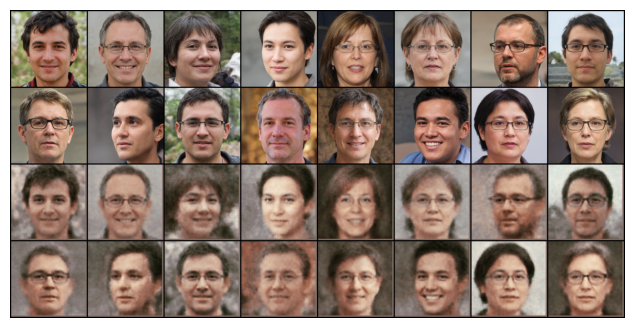

In [30]:
imgs, _ = next(iter(loader))
imgs = imgs.to(device)
mu, std, out = vae(imgs)
images = torch.cat([imgs, out], dim=0).detach().cpu()
images = torchvision.utils.make_grid(images, 8, 4)
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis("off")
plt.show()

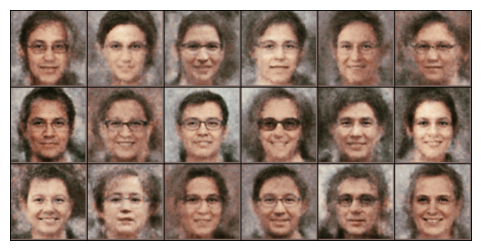

In [31]:
 plot_epoch()